In [1]:
import numpy as np, GPy, pandas as pd
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# Trajectory Simulation

We want to simulate a trajectory for the latent space with a long lengthscale and some
minor small variations:

In [2]:
import time
from run_method_comparison import run_results, seeds, methods, collect_results
from plot_definitions_datasets import plot_simulation_results_preliminary
from cellSLAM.simulation import guo_simulation

In [3]:
def run_bgplvm(Y, X_init):
    m = GPy.models.BayesianGPLVM(Y, X_init.shape[1], 
                                     X_init, kernel=GPy.kern.RBF(X_init.shape[1], ARD=False),
                                     num_inducing=25)
    
    m.update_model(False)
    m.likelihood[:] = Y.var()/10.
    m.X.variance[:] = .1
    m.kern.lengthscale.fix()
    m.likelihood.fix()
    m.X.mean.fix()
    m.update_model(True)
    
    mes = 0
    m.optimize(max_iters=500, messages=mes, clear_after_finish=True)

    m.likelihood.unfix()
    m.optimize(max_iters=500, messages=mes, clear_after_finish=True)

    m.kern.lengthscale.unfix()
    m.optimize(max_iters=1e5, messages=mes, clear_after_finish=True) 
    return m

In [4]:
res_name = 'trajectory_likelihood_only'

In [5]:
(Xsim_results_collection, 
 time_results_collection,
 runtime_collection, 
 ard_collection, 
 method_results_collection, 
 model_collection,
 pt_collection) = run_results(run_bgplvm, guo_simulation, 
                              '../diagrams/simulation/{}'.format(res_name),
                             n_repeats=10)

SLS8971...
  Iteration 0 1 2 3 4 5 6 7 8 9
SLS3551...
  Iteration 0 1 2 3 4 5 6 7 8 9
SLS3279...
  Iteration 0 1 2 3 4 5 6 7 8 9
SLS5001...
  Iteration 0 1 2 3 4 5 6 7 8 9
SLS5081...
  Iteration 0 1 2 3 4 5 6 7 8 9


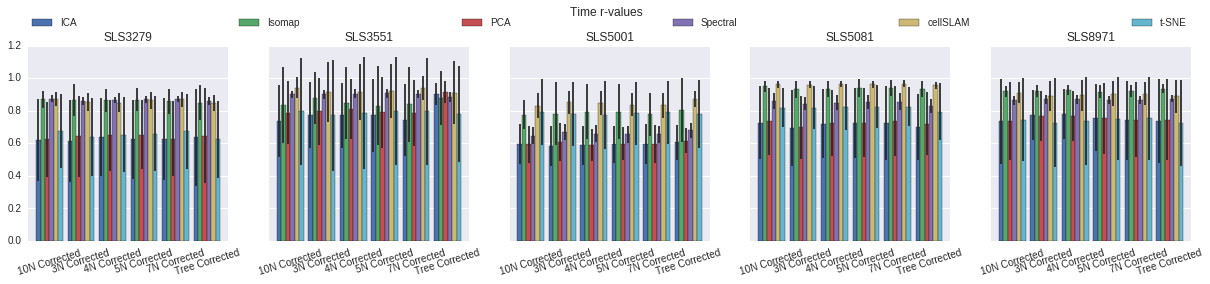

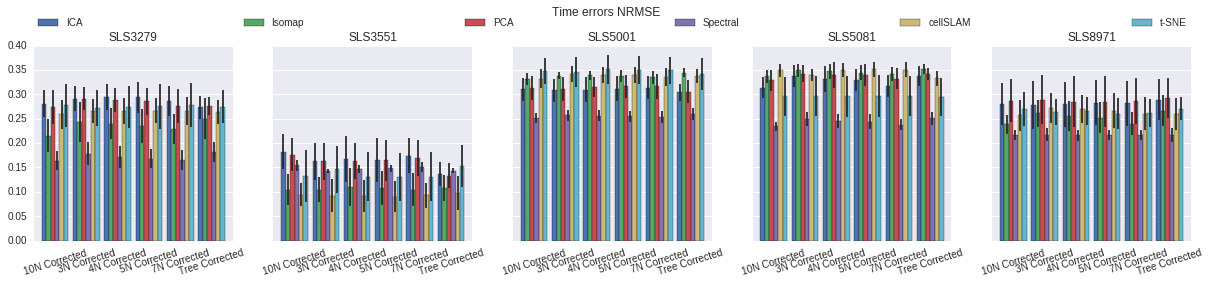

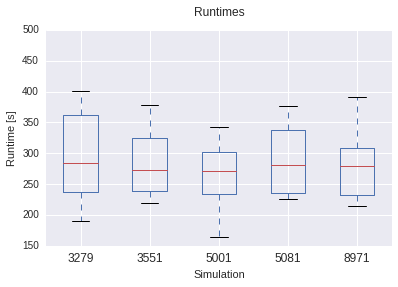

In [11]:
import os

# Collect results:
n_repeats = len(pt_collection)/len(seeds)

folder = '../supplementary/{}'.format(res_name)
if not os.path.exists(folder):
    os.makedirs(folder)

rvalues = collect_results(pt_collection, 'rvalue', n_repeats)
rvalues.to_csv(os.path.join(folder, '{}.csv'.format('time_rvalue')))
fig, first = plot_simulation_results_preliminary(rvalues)
fig.suptitle("Time r-values")
fig.savefig('../diagrams/simulation/{}/{}.pdf'.format(res_name, 'time_rvalue'))


time_errors = collect_results(time_results_collection, 'NRMSE', n_repeats)
time_errors.to_csv(os.path.join(folder, '{}.csv'.format('time')))
fig, first = plot_simulation_results_preliminary(time_errors)
fig.suptitle("Time errors NRMSE")
fig.savefig('../diagrams/simulation/{}/{}.pdf'.format(res_name, 'time'))


Xsim_errors = collect_results(Xsim_results_collection, 'NRMSE', n_repeats)
Xsim_errors.to_csv(os.path.join(folder, '{}.csv'.format('Xsim')))
fig, first = plot_simulation_results_preliminary(Xsim_errors)
fig.suptitle("Xsim errors NRMSE")
fig.savefig('../diagrams/simulation/{}/{}.pdf'.format(res_name, 'Xsim'))


fig, ax = plt.subplots(figsize=(6,4))
runtimes = pd.DataFrame(runtime_collection, 
                        index=pd.MultiIndex.from_tuples([(i,j) 
                                                         for i in seeds for j in range(n_repeats)
                                                        ]))
runtimes.to_csv(os.path.join(folder, '{}.csv'.format('runtimes')))
times = runtimes.reset_index(level=0)
times.columns = ['simulation', 'seconds']
_ = times.boxplot(by='simulation', ax=ax)
fig.suptitle('Runtimes')
ax.set_title('')
ax.set_ylabel('Runtime [s]')
ax.set_xlabel('Simulation')
fig.savefig('../diagrams/simulation/{}/{}.pdf'.format(res_name, 'runtimes'))